## Predicting House Prices - advanced regression techniques

### Initial loading of data

Loading of the training and testing data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

In [3]:
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from 'C:\\Source\\predicting-house-prices\\helper_functions.py'>

In [4]:
train_df = pd.read_csv('data/train.csv')
print('Loaded %s training rows with %s columns' % (train_df.shape[0], train_df.shape[1]))

Loaded 1460 training rows with 81 columns


In [5]:
test_df = pd.read_csv('data/test.csv')
print('Loaded %s test rows with %s columns' % (test_df.shape[0], test_df.shape[1]))

Loaded 1459 test rows with 80 columns


In [6]:
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

### Building a pipeline skeleton for all further steps

In [77]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

class NoFitMixin:
    def fit(self, X, y=None):
        return self

class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)
    
class DFFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        # non-optimized default implementation; override when a better
        # method is possible
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for _, trans, weight in self._iter())
        return pd.concat(Xs, axis=1, join='inner')

### Testing the pipeline with a very simple model and only the numerical columns

In [ ]:
from sklearn.model_selection import train_test_split

# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000002554F608268>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [11]:
predictions = pipeline.predict(X_test)

In [12]:
# Cleaning the predictions from 0 and below
predictions[predictions <= 0] = 0

In [15]:
print_benchmark(y_test, predictions, log_transform=True)

R2-score: 0.761081041605
RMSE (log): 0.549234845034476


### Eliminate right-skewed target variable

Analyzing the distribution of the target variable SalePrice

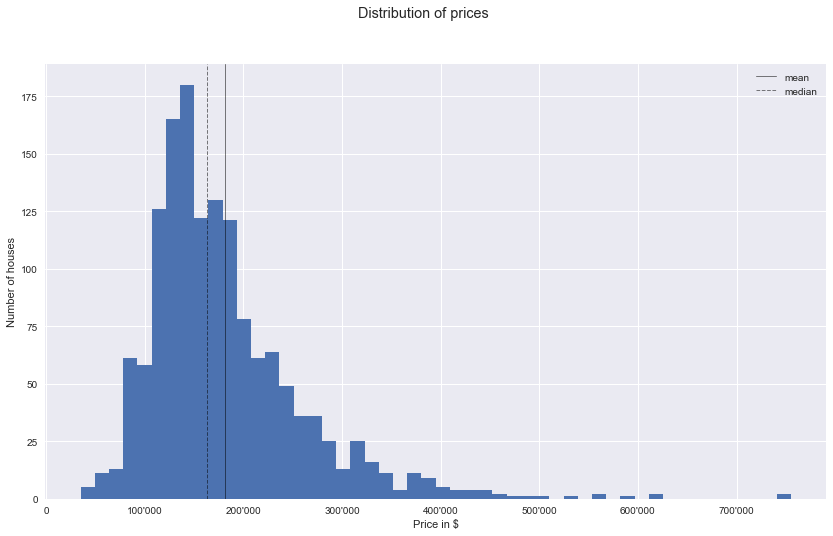

In [16]:
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))

fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(train_df['SalePrice'].mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(train_df['SalePrice'].median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(train_df.loc[:, 'SalePrice'], bins=50)
plt.show()

The sale price is heavily right-skewed so we will need to apply a log transform to even the distribution. This gives us a much better distribution

In [17]:
y = np.log1p(y)

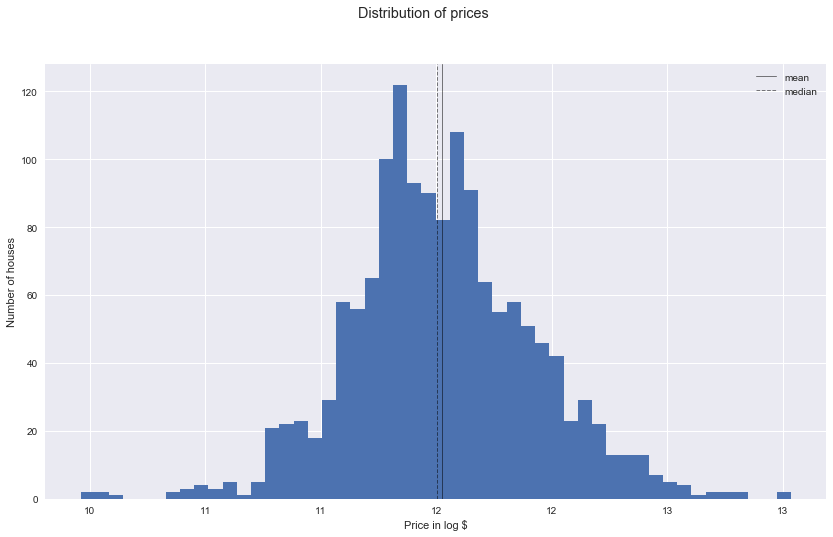

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in log $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(y.mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(y.median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(y, bins=50)
plt.show()

We now have a much better distribution and we test the pipeline with this new distributions.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000002554F608268>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [20]:
predictions = pipeline.predict(X_test)
predictions[predictions <= 0] = 0
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


We define a helper function for the process

In [45]:
def evaluate_pipeline(X_param, y_param, log_transform_param = False):
    X_train, X_test, y_train, y_test = train_test_split(X_param, y_param, test_size=.33, random_state=42)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    predictions[predictions <= 0] = 0
    print_benchmark(y_test, predictions, log_transform=log_transform_param)

In [46]:
evaluate_pipeline(X_numerical, y)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


### Eliminate outliers in the data

Accoring to the documentation there are some outliers present which we remove here after we examine their presence.

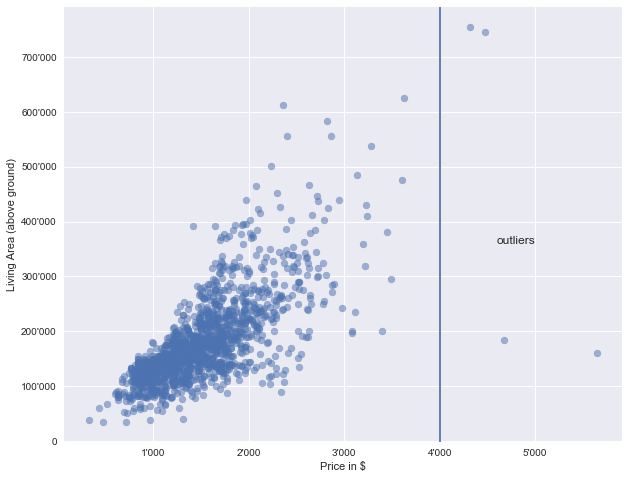

In [36]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.5)
ax.set_ylabel('Living Area (above ground)')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(4000)
ax.text(4600, 360000, 'outliers')
plt.show()

In [63]:
outliers = X[X['GrLivArea'] >= 4000]

In [64]:
print('%s outliers to remove (%s)' % (len(outliers), outliers.index))

4 outliers to remove (Int64Index([523, 691, 1182, 1298], dtype='int64'))


In [117]:
X = X.drop(outliers.index)
y = y.drop(outliers.index)

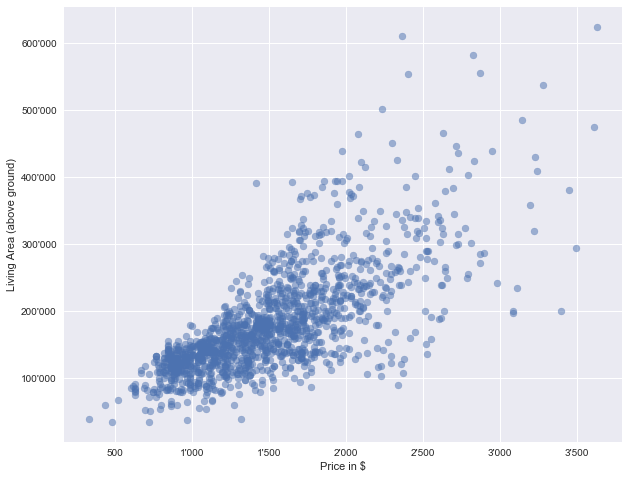

In [71]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(X['GrLivArea'], np.expm1(y), alpha=.5)
ax.set_ylabel('Living Area (above ground)')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

We test the pipeline with the removed outliers therefore we need to select the numerical features only again because we are not ready for the encoding of those

In [118]:
# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

In [73]:
evaluate_pipeline(X_numerical, y)

R2-score: 0.811045893083
RMSE (log): 0.17181598362314995


The score is a little bit better than with the outlies still in the dataset.

### Explore the direction of the data with principal component analysis

In [182]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_numerical)
X_numerical = scaler.transform(X_numerical)

In [183]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [184]:
print('Explained variance by the first 2 compoenents: %s' % pca.explained_variance_ratio_)

Explained variance by the first 2 compoenents: [ 0.18352898  0.09543763]


In [185]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

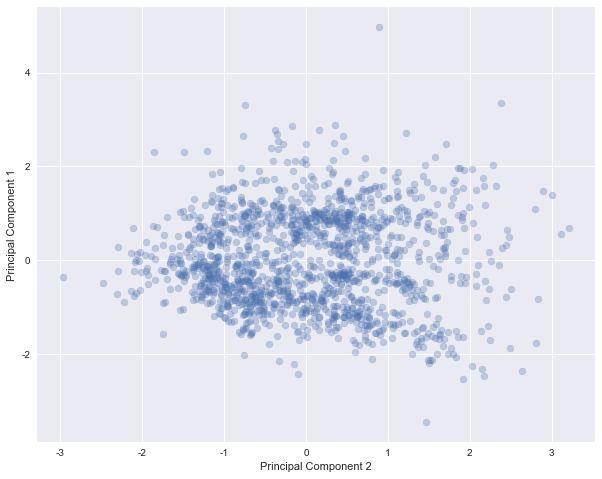

In [186]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax.set_ylabel('Principal Component 1')
ax.set_xlabel('Principal Component 2')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

But we want to analyse how many dimensions are in fact important

In [187]:
pca = PCA(whiten=True)
pca.fit(X_numerical)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [188]:
cumsum

array([ 0.18352898,  0.27896661,  0.34047822,  0.4002333 ,  0.44360774,
        0.47860357,  0.51257453,  0.54494628,  0.57681892,  0.6082521 ,
        0.63958738,  0.66920719,  0.69839373,  0.72673674,  0.75447223,
        0.78050718,  0.80556838,  0.82986338,  0.85368566,  0.87659745,
        0.89772237,  0.91577029,  0.93310012,  0.9468523 ,  0.95791541,
        0.96694865,  0.97516878,  0.98286013,  0.98869037,  0.99318327,
        0.9970844 ,  1.        ,  1.        ,  1.        ])

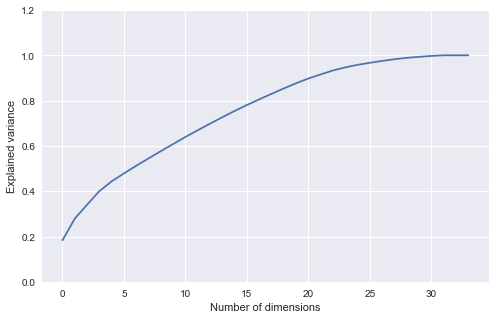

In [205]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cumsum)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Explained variance')
ax.set_ylim(0,1.2)
ax.text(15, )
plt.show()

In [191]:
pca = PCA(n_components=.95)
X_reduced = pca.fit_transform(X_numerical)

In [192]:
print('95 percent or more of the variance is eplained with %s component' % str(pca.n_components_))

95 percent or more of the variance is eplained with 25 component


With 25 components more than 95% of the variance of the data is explained.

In [196]:
X_reduced.shape

(1456, 25)

In [197]:
reduced_data = pd.DataFrame(X_reduced)

In [200]:
model = linear_model.LinearRegression()
model.fit(reduced_data, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [201]:
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(pca.transform(X_test_scaled))

In [202]:
print_benchmark(np.expm1(y_test), predictions, log_transform=True)

R2-score: 0.839405887716
RMSE (log): 0.2644742897313069


** Never forget ** :
You need to scale before doing principal component analysis

### Eliminate variables which hurt the non-coolinearity assumption